In [42]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import requests
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
from wordcloud import WordCloud,STOPWORDS
import sqlite3
import pandas as pd
from bs4 import BeautifulSoup
import os
from sklearn.model_selection import train_test_split
from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils


In [43]:
# Connect to SQLite database
conn = sqlite3.connect('reddit_data.db')

# Query to select all data from the reddit_posts table
query = "SELECT * FROM reddit_posts"

# Read data from the database into a DataFrame
data = pd.read_sql_query(query, conn)

# Close connection
conn.close()

# Display the DataFrame
data.head()

id  subreddit                                              title selftext  \
0   1  worldnews  Iran has launched drone attacks at Israel, U.S...            
1   2  worldnews  Jordan temporarily closes airspace amid fears ...            
2   3  worldnews  Israel says it is closing its airspace as it b...            
3   4  worldnews  Statement from NSC Spokesperson Adrienne Watso...            
4   5  worldnews  Germany to give financial compensation to Holo...            

   upvote_ratio  ups  downs  score link_flair_css_class           created_utc  \
0          1.00   13      0     13         palestisrael  2024-04-13T22:51:38Z   
1          0.97   31      0     31         palestisrael  2024-04-13T22:42:44Z   
2          0.92   50      0     50         palestisrael  2024-04-13T22:40:30Z   
3          0.96   85      0     85         palestisrael  2024-04-13T22:39:13Z   
4          0.80   34      0     34                 None  2024-04-13T22:11:27Z   

  kind cleaned  
0   t3    None  
1   t3    None  
2   t3    None  
3   t3    None  
4   t3    None

In [44]:
data.shape

(4795, 12)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4795 entries, 0 to 4794
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4795 non-null   int64  
 1   subreddit             4795 non-null   object 
 2   title                 4795 non-null   object 
 3   selftext              4795 non-null   object 
 4   upvote_ratio          4795 non-null   float64
 5   ups                   4795 non-null   int64  
 6   downs                 4795 non-null   int64  
 7   score                 4795 non-null   int64  
 8   link_flair_css_class  605 non-null    object 
 9   created_utc           4795 non-null   object 
 10  kind                  4795 non-null   object 
 11  cleaned               0 non-null      object 
dtypes: float64(1), int64(4), object(7)
memory usage: 449.7+ KB


In [46]:
data.selftext

0        
1        
2        
3        
4        
       ..
4790     
4791     
4792     
4793     
4794     
Name: selftext, Length: 4795, dtype: object

I extracted the text from the 'title' column of the data and used the WordCloud library to generate the word cloud. 

In [47]:
# plt.figure(figsize=(60,35))
# #subset = data['title']
# text = data['selftext'].values
# cloud1=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text))
# plt.axis('off')
# plt.title("r/politics",fontsize=40)
# plt.imshow(cloud1)

As we can see from the word cloud, the main themes are around recent developments relating to Abortion, bans and Arizona, mostly US politics heavy.

In [48]:
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from string import punctuation
stop = set(STOPWORDS)

In [49]:
import re

def lower(text):
    return text.lower()

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punctuation))

def clean_text(text):
    text = lower(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    return text

#Apply function on column
data['cleaned']=data['title'].apply(clean_text)

In [50]:
data['cleaned'].head()

0    iran launched drone attacks israel us official...
1    jordan temporarily closes airspace amid fears ...
2    israel says closing airspace braces iranian dr...
3    statement nsc spokesperson adrienne watson ira...
4    germany give financial compensation holocaust ...
Name: cleaned, dtype: object

In [51]:
from collections import Counter
cnt=Counter()

for text in data['cleaned'].values:
    for word in text.split():
        cnt[word]+=1
        
cnt.most_common(10)

[('says', 347),
 ('us', 307),
 ('israel', 296),
 ('trump', 294),
 ('gaza', 285),
 ('biden', 204),
 ('ukraine', 201),
 ('uk', 163),
 ('russian', 163),
 ('new', 160)]

In [52]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

data['cleaned'] = data['cleaned'].apply(lambda text: remove_freqwords(text))

In [53]:
data['cleaned'].head()

0            iran launched drone attacks officials say
1    jordan temporarily closes airspace amid fears ...
2         closing airspace braces iranian drone attack
3    statement nsc spokesperson adrienne watson ira...
4    germany give financial compensation holocaust ...
Name: cleaned, dtype: object

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, # sublinear TF scaling to scale term frequencies logarithmically to reduce the importance of very frequent terms
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(data.cleaned).toarray()


print("Each of the %d cleaned text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 4795 cleaned text is represented by 1954 features (TF-IDF score of unigrams and bigrams)


In [55]:
features.shape 

(4795, 1954)

# Sentiment Analysis

### With AFINN Lexicon


In [56]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn()

In [57]:
# compute sentiment scores (polarity) and labels
data['sentiment_score'] = data['cleaned'].apply(lambda x: af.score(x))
# data['sentiment_score']

In [58]:
# Add a column 'sentiment_category' based on 'sentiment_score'
data['sentiment_category'] = data['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))
# data['sentiment_category']

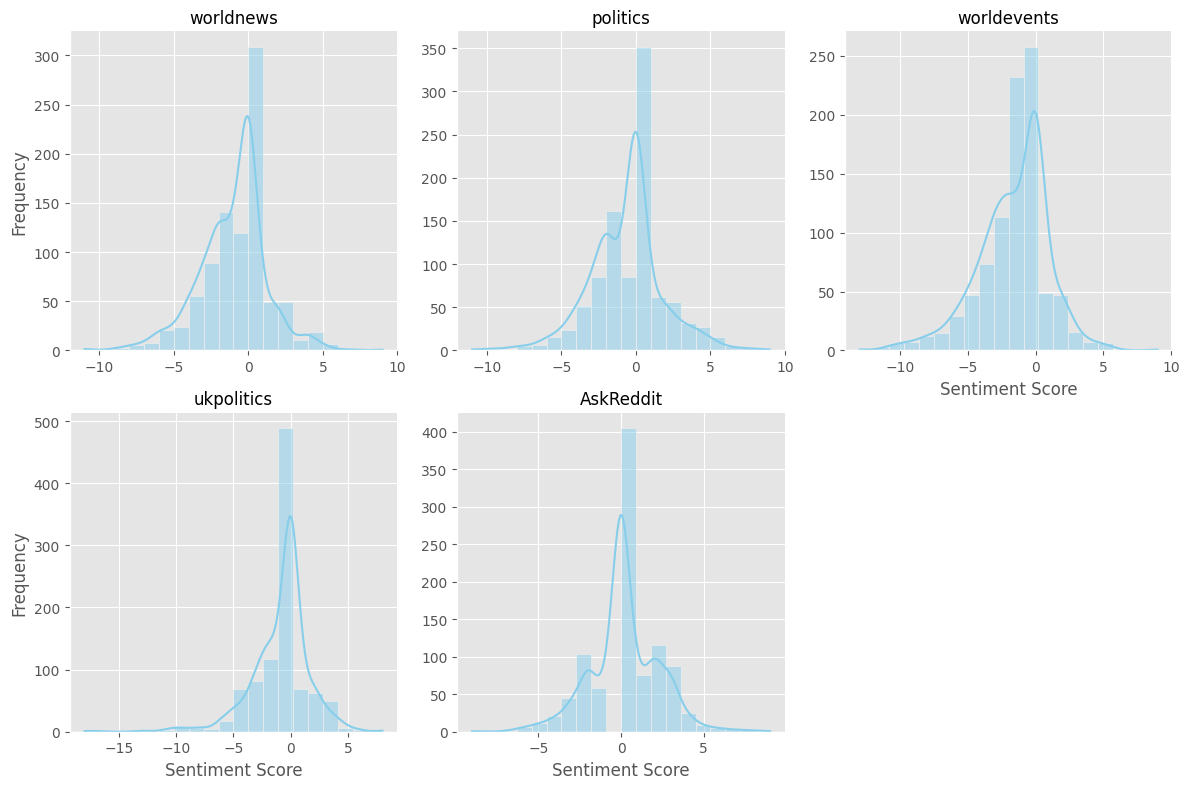

In [59]:
g = sns.FacetGrid(data, col='subreddit', col_wrap=3, height=4, sharex=False, sharey=False)

# Map histogram plot for sentiment scores to each FacetGrid
g.map(sns.histplot, 'sentiment_score', bins=20, kde=True, color='skyblue')

# Set titles for each subplot
g.set_titles("{col_name}")

# Set common labels for x and y axes
g.set_axis_labels("Sentiment Score", "Frequency")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [60]:
sentiment_counts = data['sentiment_category'].value_counts()


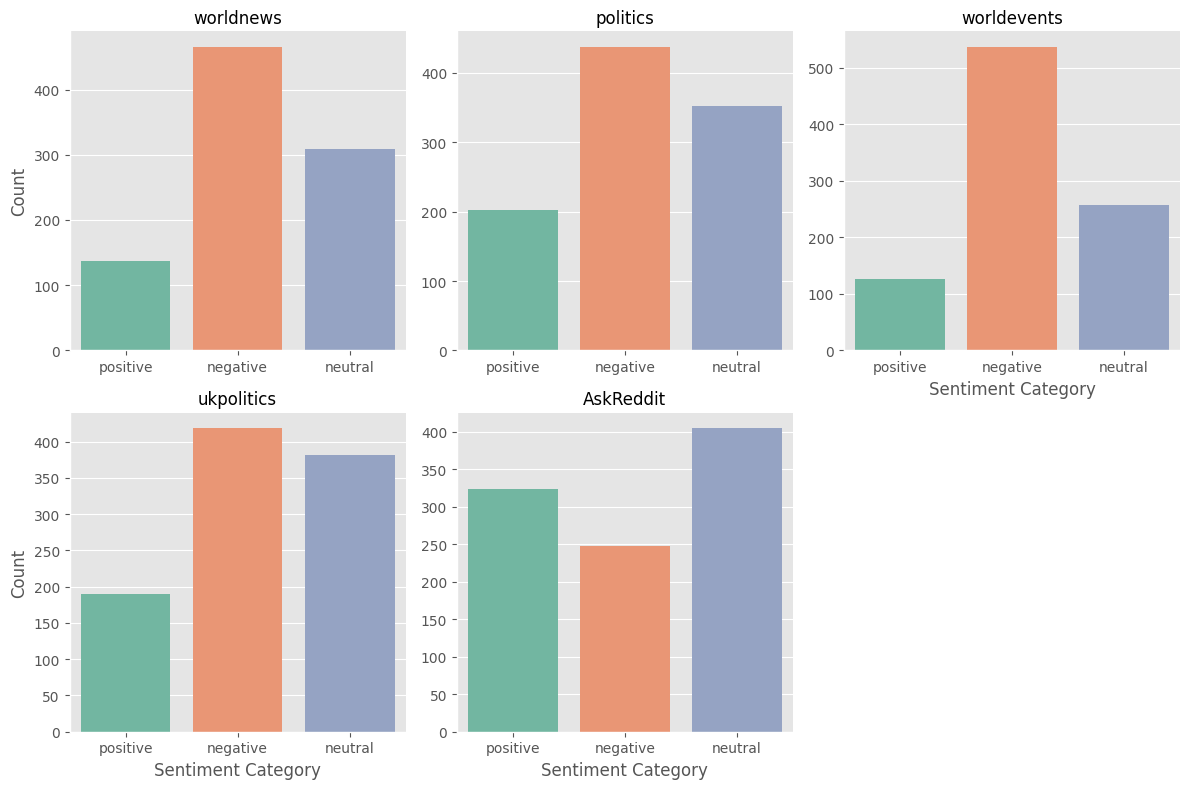

In [61]:
# Define the order of sentiment categories
order = ['positive', 'negative', 'neutral']

# Convert sentiment_category to categorical type with specified order
data['sentiment_category'] = pd.Categorical(data['sentiment_category'], categories=order, ordered=True)

# Create a FacetGrid for each subreddit
g = sns.FacetGrid(data, col='subreddit', col_wrap=3, height=4, sharex=False, sharey=False)

# Map count plot for sentiment categories to each FacetGrid
g.map_dataframe(sns.countplot, 'sentiment_category', palette='Set2')

# Set titles for each subplot
g.set_titles("{col_name}")

# Set common labels for x and y axes
g.set_axis_labels("Sentiment Category", "Count")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [62]:
sorted = data.sort_values(by='sentiment_score')
#sorted['cleaned'].head()

In [63]:
#pd.set_option('display.max_colwidth', None)
# print(sorted['post'].head())

In [64]:
#print(sorted['post'].tail(2))

### With TextBlob

In [65]:
from textblob import TextBlob


In [66]:
#data['post']

In [67]:
# compute sentiment scores (polarity) and labels
data['sentiment_score_tb'] = data['cleaned'].apply(lambda x: round(TextBlob(x).sentiment.polarity, 3))
#data['sentiment_score_tb']

#sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]


In [68]:
# Add a column 'sentiment_category' based on 'sentiment_score'
data['sentiment_category_tb'] = data['sentiment_score_tb'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))
#data['sentiment_category_tb']

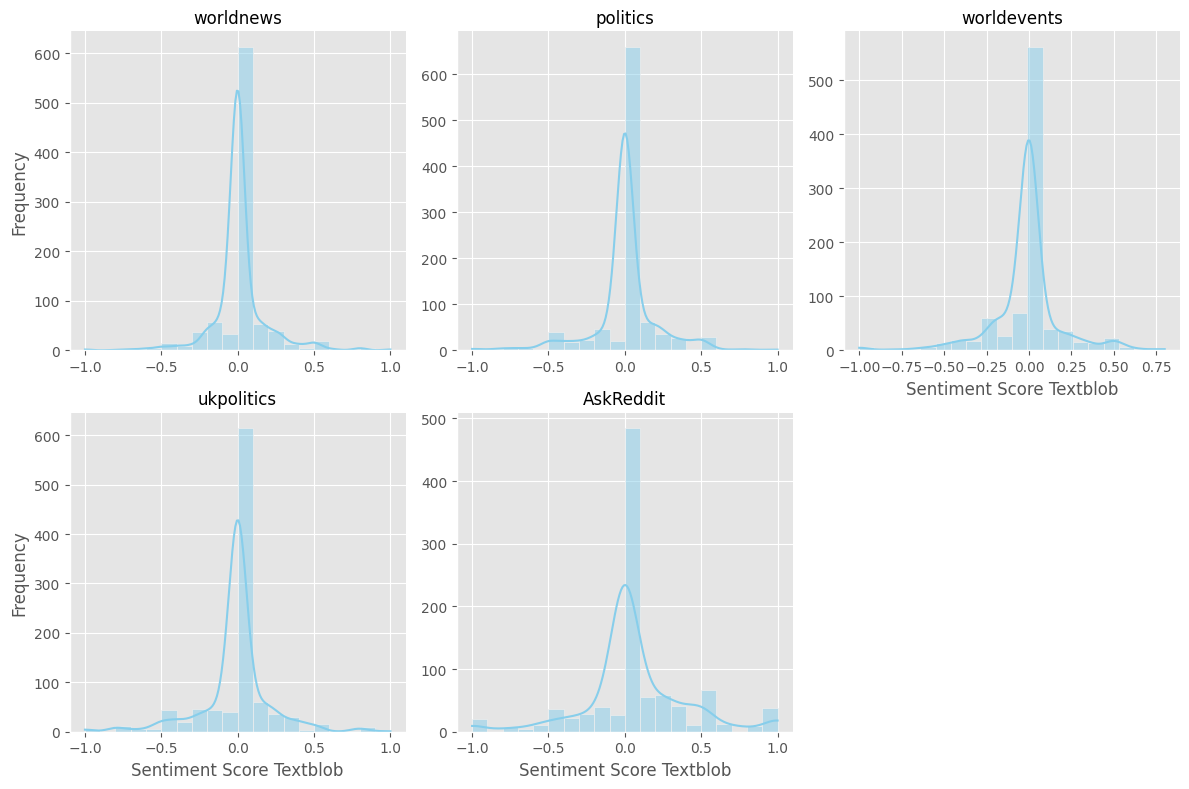

In [69]:
g = sns.FacetGrid(data, col='subreddit', col_wrap=3, height=4, sharex=False, sharey=False)

# Map histogram plot for sentiment scores to each FacetGrid
g.map(sns.histplot, 'sentiment_score_tb', bins=20, kde=True, color='skyblue')

# Set titles for each subplot
g.set_titles("{col_name}")

# Set common labels for x and y axes
g.set_axis_labels("Sentiment Score Textblob", "Frequency")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [70]:
sentiment_counts_tb = data['sentiment_category_tb'].value_counts()


In [71]:
sentiment_counts_tb

neutral     2700
positive    1122
negative     973
Name: sentiment_category_tb, dtype: int64

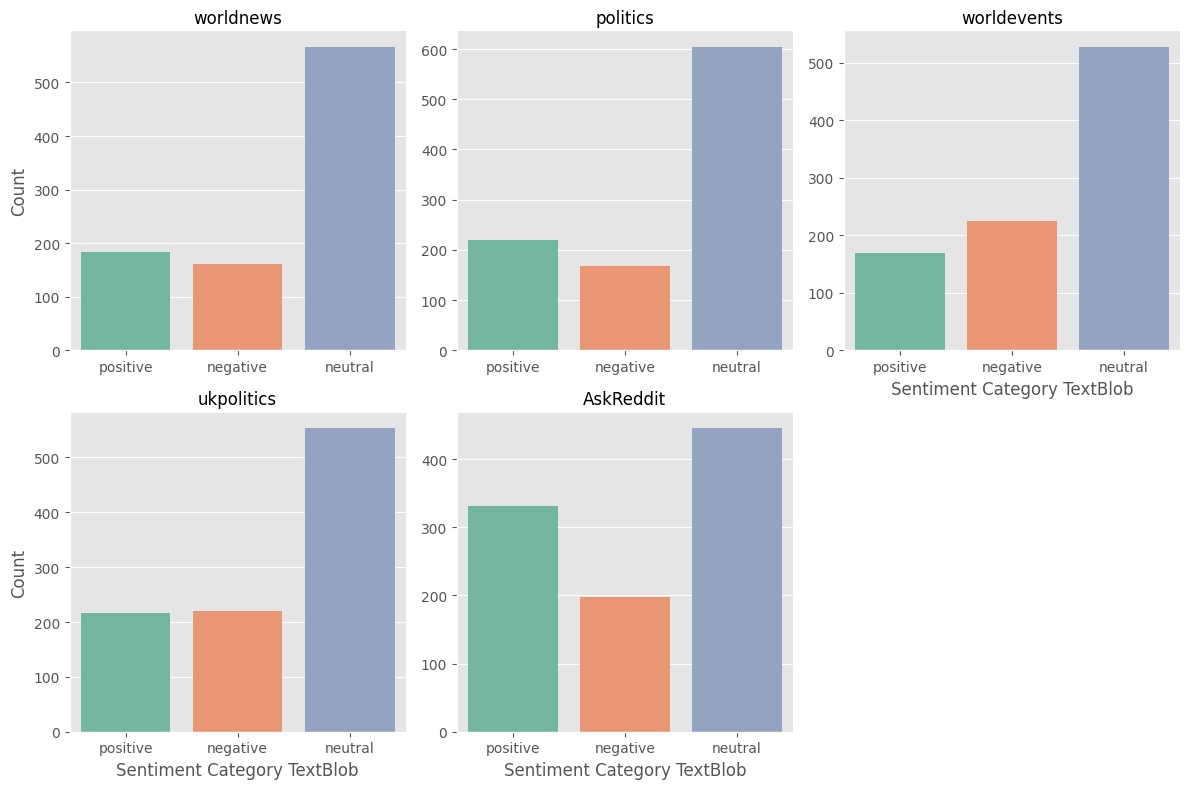

In [72]:
# Define the order of sentiment categories
order = ['positive', 'negative', 'neutral']

# Convert sentiment_category to categorical type with specified order
data['sentiment_category_tb'] = pd.Categorical(data['sentiment_category_tb'], categories=order, ordered=True)

# Create a FacetGrid for each subreddit
g = sns.FacetGrid(data, col='subreddit', col_wrap=3, height=4, sharex=False, sharey=False)

# Map count plot for sentiment categories to each FacetGrid
g.map_dataframe(sns.countplot, 'sentiment_category_tb', palette='Set2')

# Set titles for each subplot
g.set_titles("{col_name}")

# Set common labels for x and y axes
g.set_axis_labels("Sentiment Category TextBlob", "Count")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [73]:
sorted_tb = data.sort_values(by='sentiment_score_tb')
# sorted_tb['cleaned'].head()

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
 

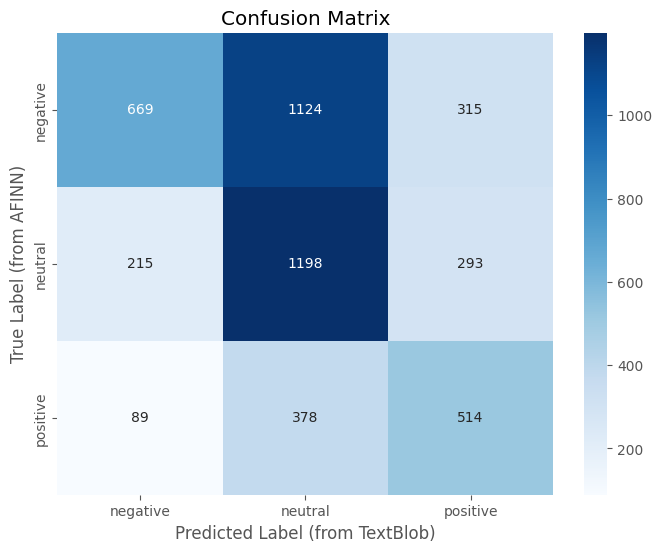

In [75]:
# True labels (ground truth)
true_labels = data['sentiment_category']

# Predicted labels
predicted_labels = data['sentiment_category_tb']  

# Define the list of classes
classes = ['negative', 'neutral', 'positive']

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label (from TextBlob)')
plt.ylabel('True Label (from AFINN)')
plt.show()

### With VADER

In [76]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [77]:
sia = SentimentIntensityAnalyzer()

In [78]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['cleaned']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/4795 [00:00<?, ?it/s]

In [79]:
#res

In [80]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(data, how='left')
# vaders.head()

In [81]:
#vaders.columns

In [82]:
test = vaders[['compound','sentiment_score', 'sentiment_score_tb','upvote_ratio', 'ups', 'downs', 'score']] 

In [83]:
#test.sort_values(by='ups', ascending=False)

In [84]:
#  # Select relevant columns from the dataframe
# metrics = test[['compound', 'sentiment_score', 'sentiment_score_tb', 'upvote_ratio', 'ups', 'downs', 'score']]
# # Create a pairplot
# sns.pairplot(metrics)
# plt.tight_layout()
# plt.show()

### Roberta Pretrained Model

In [85]:
from transformers import AutoTokenizer

In [86]:
from transformers import AutoModelForSequenceClassification

In [87]:
from scipy.special import softmax

In [88]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.4075, 0.5261, 0.3065],
        [0.0183, 0.6651, 0.2955],
        [0.9480, 0.5425, 0.3355],
        [0.9095, 0.8906, 0.8154],
        [0.1063, 0.8509, 0.4512]])


In [89]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [90]:
def polarity_scores_roberta(text, max_length=512):
    # Tokenize the input text using the AutoTokenizer
    inputs = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True)

   # Check if the input was truncated
    if len(inputs['input_ids'][0]) >= max_length:
        print(f'Warning: Input text truncated for id: {myid}')
        
    # Ensure that 'input_ids' and 'attention_mask' are present in inputs
    if 'input_ids' in inputs and 'attention_mask' in inputs:
        # Call the RoBERTa model
        with torch.no_grad():
            output = model(**inputs)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores, axis=0).tolist()
    
    # Define labels for sentiment classes
        labels = ['negative', 'neutral', 'positive']
        
        # Create a dictionary of sentiment scores
        scores_dict = {f'roberta_{label}': score for label, score in zip(labels, scores)}
        
        return scores_dict
    else:
        raise ValueError('Input tensor dimensions are invalid')

In [91]:
# def polarity_scores_roberta(text):
#     encoded_text = tokenizer(text, return_tensors='pt')
#     output = model(**encoded_text)
#     scores = output[0][0].detach().numpy()
#     scores = softmax(scores)
#     scores_dict = {
#         'roberta_neg' : scores[0],
#         'roberta_neu' : scores[1],
#         'roberta_pos' : scores[2]
#     }
#     return scores_dict

In [92]:
truncated_indices = []
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['cleaned']
        myid = row['id']
        
        # Calculate RoBERTa polarity scores
        roberta_result = polarity_scores_roberta(text)
        
        # Process Vader results
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
            
        # Combine Vader and RoBERTa results
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')
        truncated_indices.append(i)

  0%|          | 0/4795 [00:00<?, ?it/s]

In [93]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(data, how='left')

In [94]:
# results_df.head()

# Political Bias

In [95]:
labelled_data = []

In [96]:
center_dir = '/Users/surajkwork/Documents/Projects/subredditpoliticalbias/AllSides/Center Data'
left_dir = '/Users/surajkwork/Documents/Projects/subredditpoliticalbias/AllSides/Left Data'
right_dir = '/Users/surajkwork/Documents/Projects/subredditpoliticalbias/AllSides/Right Data'


In [97]:

# Loop over the files in the Center Data folder and extract their content
for filename in os.listdir(center_dir):
    with open(os.path.join(center_dir, filename), 'r') as f:
        content = f.read()
        labelled_data.append({'text': content, 'bias': 'Center'})

# Loop over the files in the Left Data folder and extract their content
for filename in os.listdir(left_dir):
    with open(os.path.join(left_dir, filename), 'r') as f:
        content = f.read()
        labelled_data.append({'text': content, 'bias': 'Left'})

# Loop over the files in the Right Data folder and extract their content
for filename in os.listdir(right_dir):
    with open(os.path.join(right_dir, filename), 'r') as f:
        content = f.read()
        labelled_data.append({'text': content, 'bias': 'Right'})

# Create a Pandas DataFrame from the data
df = pd.concat([pd.DataFrame([d]) for d in labelled_data], ignore_index=True)

df.head()

text    bias
0  The Trump administration is shattering a grues...  Center
1                                                ...  Center
2  WASHINGTON (AP) — AstraZeneca reported Monday ...  Center
3  Donald Trump says the government should get a ...  Center
4              \tBefore the highly-anticipated fi...  Center

In [104]:
# Calculate the number of words in each row
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Calculate the average number of words
average_word_count = np.mean(df['word_count'])

print("Average number of words per row:", average_word_count)

Average number of words per row: 580.08547402373


In [99]:
df = df.iloc[np.random.permutation(len(df))]


In [100]:
df['bias'].value_counts()

Left      7803
Right     5563
Center    3996
Name: bias, dtype: int64

In [101]:
df['bias'] = df['bias'].replace(['Left','Center','Right'],[0,1,2])

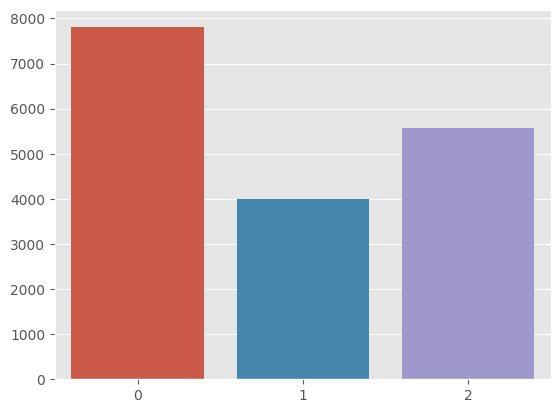

In [102]:
bias_vals = df['bias'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
plt.show();

In [103]:
def clean(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = text.replace('„','')
    text = text.replace('“','')
    text = text.replace('"','')
    text = text.replace('\'','')
    text = text.replace('-','')
    text = text.lower()
    return text
def remove_stopwords(content):
    for word in stop:
        content = content.replace(' '+word+' ',' ')
    return content
df['text'] = df['text'].apply(clean)
df['text'] = df['text'].apply(remove_stopwords)

In [105]:
train, test = train_test_split(df, test_size=0.2)

Now we take each of the train and test sets and tokenize them. 
First a function that tokenizes the text by first using the nltk.sent_tokenize() function to split the text into sentences and then the nltk.word_tokenize() function to split each sentence into words. 
Also checks if the length of each word is less than 3, and if it is, it skips that word. And then it appends the lower-cased word to a list of tokens.

The function is then applied to the train and test dataframes. For each row in the dataframe, the resulting tokens are passed as the words argument to the TaggedDocument() constructor along with the corresponding bias label. The resulting TaggedDocument objects are collected in a list and stored in the train_tagged and test_tagged variables. These TaggedDocument objects are used as input to train the Doc2Vec model, where each document in the dataset is represented by a unique vector.

In [28]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 3:
                continue
            tokens.append(word.lower())
    return tokens

In [106]:
 
train_tagged = train.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text']), tags= [r.bias]), axis=1)
test_tagged = test.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.bias]), axis=1)

## Doc2Vec Feature Vector Generation 
The Doc2Vec algorithms encodes a whole document of text into a vector of the size we choose, as opposed to individual words. The Doc2Vec vectors are able to represent the theme or overall meaning of a document. It uses the word similarities learned during training to construct a vector that will predict the words in a new document.

In [107]:
cores = multiprocessing.cpu_count()
model = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, sample=0, min_count=2, workers=cores)

In [108]:
model.build_vocab(train_tagged.values)
model.train(utils.shuffle(train_tagged.values),
total_examples=len(train_tagged.values),epochs=30)

model.save("doc2vec_articles.model")

Now I want a function which takes in a trained Doc2Vec model and the set of tagged documents to create two arrays, classes and features.

For each tagged document in sents, the code will call model.infer_vector() method to generate a feature vector for that document. The feature vector is then added to the features array, and the class label for the document (i.e. the bias in this case) is added to the classes array.

In [109]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    classes, features = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return features, classes


In [110]:
# PV_DBOW encoded text
train_x, train_y = vec_for_learning(model, train_tagged)
test_x, test_y = vec_for_learning(model, test_tagged)

## Classification Models 

In [111]:
from sklearn.naive_bayes import GaussianNB

In [112]:
bayes = GaussianNB()
bayes.fit(train_x,train_y)

def acc(true, pred):
  acc = 0
  for x,y in zip(true,pred):
    if(x == y): acc += 1
  return acc/len(pred)
print(acc(test_y,bayes.predict(test_x)))


0.6847106248200403


In [113]:
from sklearn.ensemble import RandomForestClassifier


In [114]:
forest = RandomForestClassifier(n_estimators=50)
forest.fit(train_x,train_y)
print(acc(test_y,forest.predict(test_x)))


0.6576446875899798


In [115]:
from sklearn.svm import SVC


In [116]:
svc = SVC()

svc.fit(train_x,train_y)
print(acc(test_y,svc.predict(test_x)))

0.7860639216815434


Since the Support Vector classifier has the best results on the test data set, we will use this to predict the biases for the subreddit texts.

Let's create a new column for label, which will be necessary for the tagging process, and also for generating the final predictions.

In [117]:
data['Label'] = 0


THIS STEP IS WRONG. IT TAGS WORDS WITH A LABEL.

In [118]:
data['cleaned']

0               iran launched drone attacks officials say
1       jordan temporarily closes airspace amid fears ...
2            closing airspace braces iranian drone attack
3       statement nsc spokesperson adrienne watson ira...
4       germany give financial compensation holocaust ...
                              ...                        
4790    something want tell friends andor family afrai...
4791                                 best advice received
4792                                     expats miss home
4793      kids play outside anymore even using technology
4794                    you’re good person pretend be not
Name: cleaned, Length: 4795, dtype: object

In [119]:
data_tokenized = data.apply(lambda r: tokenize_text(r['cleaned']), axis=1)

# data_tokenized = tokenize_text(data['cleaned'])
data_tokenized.head()


0     [iran, launched, drone, attacks, officials, say]
1    [jordan, temporarily, closes, airspace, amid, ...
2    [closing, airspace, braces, iranian, drone, at...
3    [statement, nsc, spokesperson, adrienne, watso...
4    [germany, give, financial, compensation, holoc...
dtype: object

THIS STEP IS WRONG AS WELL. IT CALLS VEC_FOR_LEARNING WHICH INFERS SOMETHING FROM THE DOC2VEC MODEL. 
NEED TO RELOOK.

In [121]:
test_x

(array([ 0.14387119, -0.05668265, -0.25834146,  0.10502268, -0.09757422,
        -0.34130713, -0.3652567 , -0.04133579, -0.15288995,  0.14191578,
         0.3615415 , -0.47245696, -0.09033906,  0.13484557, -0.28554764,
         0.08989523,  0.84622216,  0.35996696, -0.21808499,  0.30303556,
        -0.44231215, -0.01627462, -0.50958586,  0.17208715, -0.6441013 ,
        -0.46317312, -0.44242418, -0.01864466,  0.01501766, -0.15950492,
         0.10234007,  0.35384026, -0.4292283 , -0.44798997, -0.1663487 ,
         0.09391112, -1.0473635 , -0.304473  ,  0.14762077, -0.2981214 ,
        -0.14925945, -0.40196398,  0.3431627 , -0.16026373,  0.2320513 ,
        -0.55949765, -0.30241314,  0.4223379 , -0.24497557, -0.32165915,
        -0.22988182, -0.1542472 ,  0.24801938,  0.4044022 ,  0.24294406,
         0.09381115,  0.24681388, -0.03087831,  0.15927635, -0.1201852 ,
         0.21315639,  0.7480782 , -0.63260883,  0.04955921,  0.08338062,
        -0.06266547,  0.9951456 ,  0.46005148, -0.4

In [122]:
data_tokenized

0        [iran, launched, drone, attacks, officials, say]
1       [jordan, temporarily, closes, airspace, amid, ...
2       [closing, airspace, braces, iranian, drone, at...
3       [statement, nsc, spokesperson, adrienne, watso...
4       [germany, give, financial, compensation, holoc...
                              ...                        
4790    [something, want, tell, friends, andor, family...
4791                             [best, advice, received]
4792                                 [expats, miss, home]
4793    [kids, play, outside, anymore, even, using, te...
4794                    [you, good, person, pretend, not]
Length: 4795, dtype: object

In [123]:
data_text = [' '.join(tokens) for tokens in data_tokenized]


In [125]:
tfidf_vectorizer = TfidfVectorizer()

X = tfidf_vectorizer.fit_transform(data_text)


In [126]:
X = tfidf_vectorizer.fit_transform(data_text)

bias = svc.predict(X)


ValueError: X has 9685 features, but SVC is expecting 300 features as input.

In [100]:
bias.mean()

0.756294058408862

In [101]:
data['Label'] = bias
data.head()

id subreddit                                              title selftext  \
0   1  politics  Trump Jokes About How Longtime Aide Could End ...            
1   2  politics  US to probe if Chinese cars pose national data...            
2   3  politics  Irish taoiseach and Spanish PM to discuss Pale...            
3   4  politics  Why Trump’s ‘hush money’ case is bigger than h...            
4   5  politics  1864 AZ Speaker of the house who helped pass t...            

   upvote_ratio  ups  downs  score link_flair_css_class           created_utc  \
0          1.00    3      0      3                 None  2024-04-12T09:54:31Z   
1          1.00    4      0      4                 None  2024-04-12T09:41:11Z   
2          0.54    1      0      1                 None  2024-04-12T09:09:41Z   
3          0.94   15      0     15                 None  2024-04-12T09:01:51Z   
4          0.86   35      0     35                 None  2024-04-12T08:20:41Z   

  kind                                            cleaned  Label  
0   t3         trump jokes longtime aide end career flash      0  
1   t3  us probe chinese cars pose national data secur...      2  
2   t3  irish taoiseach spanish pm discuss palestine n...      0  
3   t3        trump’s ‘hush money’ case bigger hush money      0  
4   t3  1864 az speaker house helped pass abortion law...      0

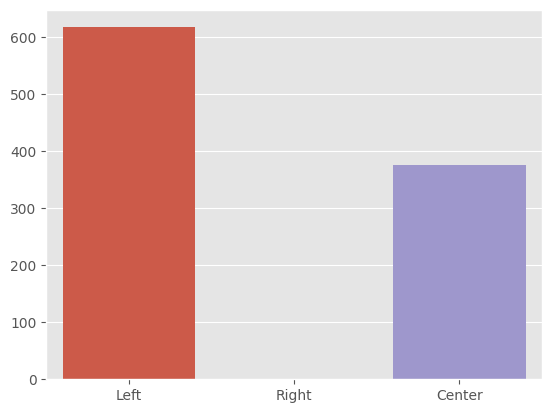

In [103]:
bias_vals = data['Label'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
tick_labels = ['Left', 'Center', 'Right']
plt.xticks(bias_vals.index, tick_labels)
plt.show()